In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Set seed for reproducibility
np.random.seed(42)
n_records = 3000

In [4]:
data = {
    # Socio-Economic Features 
    'age': np.random.randint(18, 70, n_records),
    'income': np.random.randint(20000, 150000, n_records),
    'employment_years': np.random.randint(0, 40, n_records),
    'education_level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_records),
    'marital_status': np.random.choice(['Single', 'Married', 'Divorced'], n_records),
    'home_ownership': np.random.choice(['Rent', 'Mortgage', 'Own'], n_records),
    'num_dependents': np.random.randint(0, 5, n_records),
    'zip_code_region': np.random.choice(['North', 'South', 'East', 'West'], n_records),
    
    # Financial & Credit History Features 
    'loan_amount': np.random.randint(1000, 50000, n_records),
    'credit_score': np.random.randint(300, 850, n_records),
    'cred_hist_length': np.random.randint(1, 30, n_records),
    'num_existing_loans': np.random.randint(0, 5, n_records),
    'total_debt': np.random.randint(500, 100000, n_records),
    'checking_acc_balance': np.random.randint(0, 20000, n_records),
    'savings_acc_balance': np.random.randint(0, 50000, n_records),
    'previous_defaults': np.random.choice([0, 1], n_records, p=[0.9, 0.1]),
    'credit_card_utilization': np.random.uniform(0, 1, n_records),
    'num_late_payments_last_year': np.random.randint(0, 12, n_records),
    'inquiries_last_6_months': np.random.randint(0, 10, n_records),
    'has_co_signer': np.random.choice([0, 1], n_records),
    'loan_purpose': np.random.choice(['Personal', 'Education', 'Medical', 'Home Improvement'], n_records),
}

In [19]:

df = pd.read_csv(r'"C:\Users\Sumit\Credit Risk Data"')
df['debt_to_income_ratio'] = df['total_debt'] / df['income']

# Generate Target Variable
risk_score = (0.4 * (1 - (df['credit_score'] / 850)) + 
              0.4 * (df['debt_to_income_ratio'] / 5) + 
              0.4 * np.random.rand(n_records))
df['target_default'] = (risk_score > 0.6).astype(int)

print("Dataset Overview:")
df.head()

Dataset Overview:


,age,income,employment_years,education_level,marital_status,home_ownership,num_dependents,zip_code_region,loan_amount,credit_score,...,checking_acc_balance,savings_acc_balance,previous_defaults,credit_card_utilization,num_late_payments_last_year,inquiries_last_6_months,has_co_signer,loan_purpose,debt_to_income_ratio,target_default
0,56,96272,27,PhD,Divorced,Rent,4,North,13427,679,...,10292,19887,1,0.795846,3,9,1,Home Improvement,0.586162,0
1,69,57643,20,Master,Single,Own,1,South,41251,536,...,15030,28536,0,0.154912,8,3,1,Home Improvement,0.328574,0
2,46,70408,12,Bachelor,Married,Mortgage,2,West,35131,775,...,15465,30103,0,0.538357,8,2,1,Medical,0.836652,0
3,32,63950,26,Master,Single,Rent,0,East,37727,428,...,13942,14400,0,0.766624,2,6,0,Medical,1.280125,0
4,60,76849,35,Master,Married,Rent,1,North,26165,809,...,459,34843,0,0.988305,9,9,0,Personal,0.408567,0


In [11]:
print("Class Distribution:")
print(df['target_default'].value_counts())

Class Distribution:
target_default
0    2729
1     271
Name: count, dtype: int64


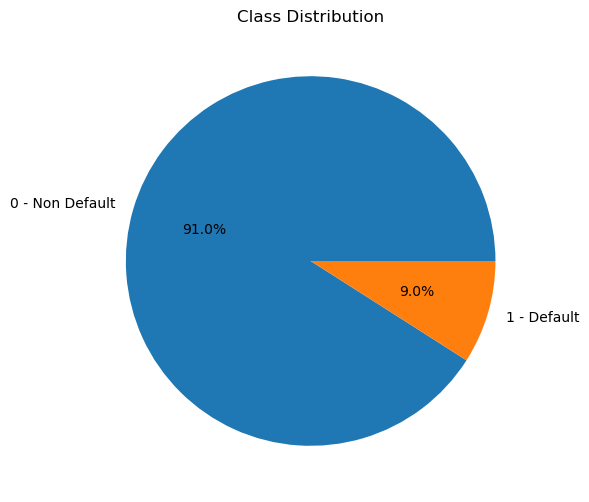

In [15]:
# EXPLORATORY DATA ANALYSIS
non_default = (df['target_default'] == 0).sum()
default = (df['target_default'] == 1).sum()
classes = ['0 - Non Default', '1 - Default'] 

plt.figure(figsize=(8, 6))
plt.pie([non_default, default], labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

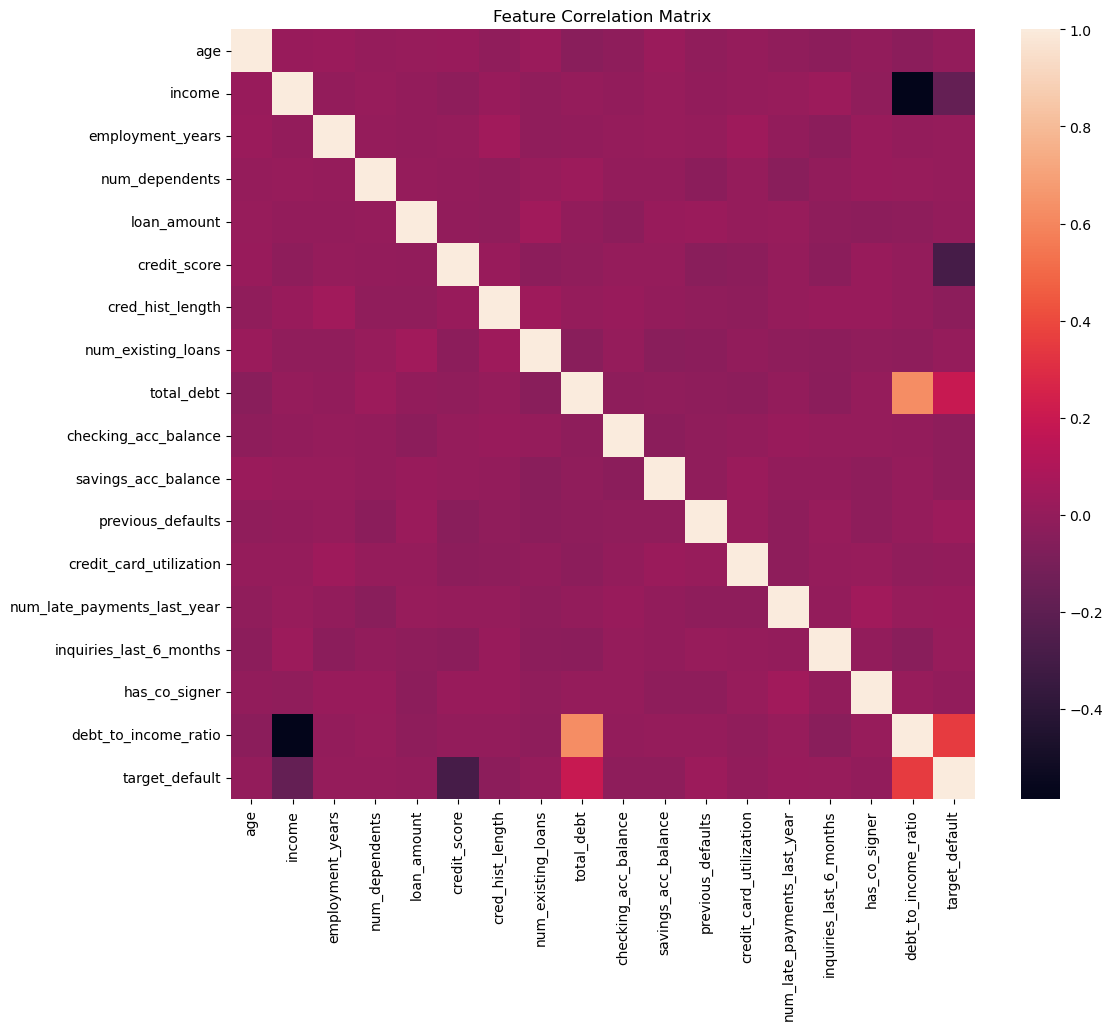

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True))
plt.title('Feature Correlation Matrix')
plt.show()

In [23]:
# DATA PREPROCESSING
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop('target_default', axis=1)
y = df['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Enhanced SMOTE with optimized sampling
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=0.8)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"\nOriginal Training Class Distribution: {np.bincount(y_train)}")
print(f"Resampled Training Class Distribution: {np.bincount(y_train_res)}")


Original Training Class Distribution: [2183  217]
Resampled Training Class Distribution: [2183 1746]


In [25]:
# MODEL BUILDING - STACKED ENSEMBLE WITH CLASS BALANCING
scale_pos_weight = len(y_train_res[y_train_res == 0]) / len(y_train_res[y_train_res == 1])

base_models = [
    ('xgb', XGBClassifier(
        n_estimators=150, 
        learning_rate=0.05, 
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=150, 
        learning_rate=0.05,
        max_depth=6,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )),
    ('rf', RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
]

stack_model = StackingClassifier(
    estimators=base_models, 
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5
)

print("\nTraining Stacked Ensemble Model...")
stack_model.fit(X_train_res, y_train_res)
print("Model training complete!")


Training Stacked Ensemble Model...
Model training complete!


In [44]:
# THRESHOLD OPTIMIZATION FOR CLASS 1 PERFORMANCE
y_probs = stack_model.predict_proba(X_test)[:, 1]

# Find optimal threshold for balanced performance
best_threshold = 0.35
best_f1 = 0

for threshold in np.arange(0.2, 0.5, 0.01):
    y_pred_temp = (y_probs >= threshold).astype(int)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred_temp, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nOptimal Threshold: {best_threshold:.3f}")

y_pred_optimized = (y_probs >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_optimized, target_names=['Non-Default', 'Default']))

roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nFinal ROC-AUC Score: {roc_auc:.2f}")


Optimal Threshold: 0.350
              precision    recall  f1-score   support

 Non-Default       0.96      0.92      0.94       546
     Default       0.43      0.59      0.50        54

    accuracy                           0.89       600
   macro avg       0.70      0.76      0.72       600
weighted avg       0.91      0.89      0.90       600


Final ROC-AUC Score: 0.88


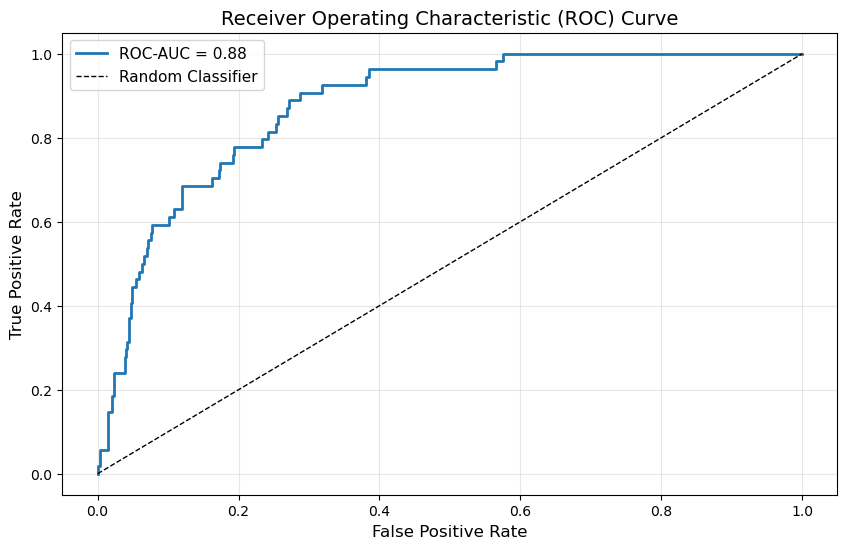

In [29]:
# ROC CURVE VISUALIZATION
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()

In [32]:
# HYPERPARAMETER TUNING 
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_tune = XGBClassifier(
    tree_method='hist', 
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_grid,
    n_iter=10, 
    scoring='roc_auc', 
    cv=3, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

print("HYPERPARAMETER TUNING")
random_search.fit(X_train_res, y_train_res)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best ROC-AUC Score from Tuning: {random_search.best_score_:.4f}")

HYPERPARAMETER TUNING
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best ROC-AUC Score from Tuning: 0.9855


C:\Users\Sumit\AppData\Local\Temp\ipykernel_23100\1663953831.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


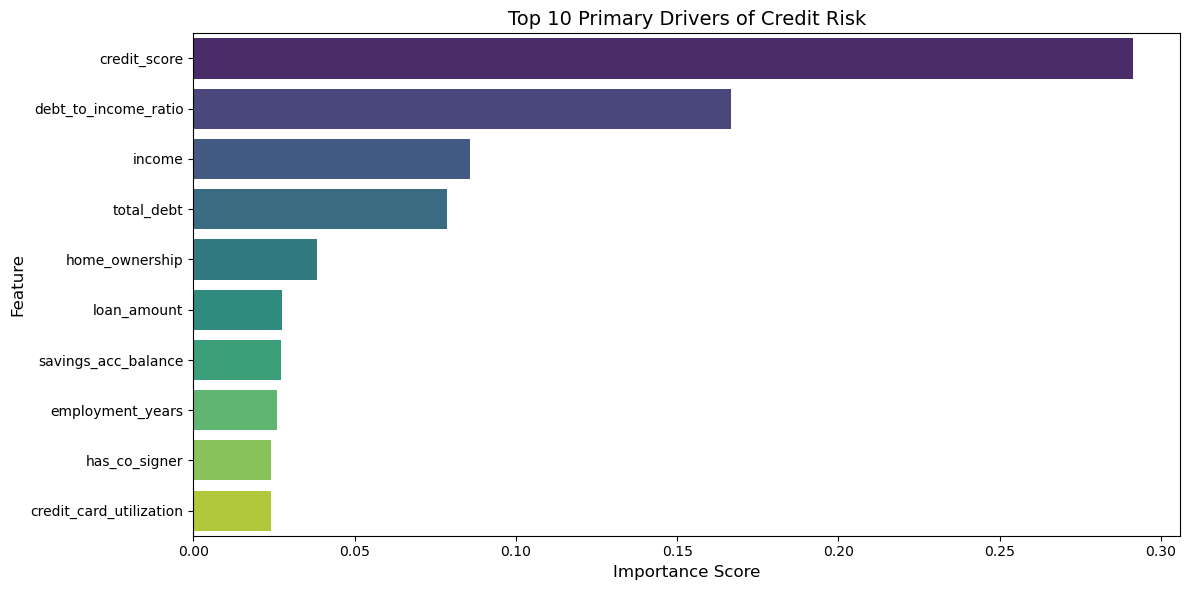

PRIMARY DRIVERS OF CREDIT RISK
                Feature  Importance
           credit_score    0.291330
   debt_to_income_ratio    0.166583
                 income    0.085811
             total_debt    0.078584
         home_ownership    0.038264
            loan_amount    0.027564
    savings_acc_balance    0.027201
       employment_years    0.026006
          has_co_signer    0.024100
credit_card_utilization    0.023956


In [34]:
# FEATURE IMPORTANCE ANALYSIS
rf_component = stack_model.named_estimators_['rf']
importances = rf_component.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Primary Drivers of Credit Risk', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("PRIMARY DRIVERS OF CREDIT RISK")
print(importance_df.to_string(index=False))

In [53]:
# STABILITY ANALYSIS

xgb_cv_scores = cross_val_score(
    XGBClassifier(scale_pos_weight=scale_pos_weight), 
    X_train_res, y_train_res, cv=4, scoring='roc_auc'
)
xgb_std = xgb_cv_scores.std()

stack_cv_scores = cross_val_score(
    stack_model, X_train_res, y_train_res, cv=4, scoring='roc_auc'
)
stack_std = stack_cv_scores.std()

stability_improvement = ((xgb_std - stack_std) / xgb_std) * 100

print(f"Single Model (XGBoost) Std Dev: {xgb_std:.4f}")
print(f"Stacked Ensemble Std Dev: {stack_std:.4f}")
print(f"Stability Improvement: {stability_improvement:.2f}%")

Single Model (XGBoost) Std Dev: 0.0146
Stacked Ensemble Std Dev: 0.0126
Stability Improvement: 13.42%


In [38]:
df.to_csv('Processed_Credit_Risk_Data.csv', index=False)